# Data Preprocessing: Assignment 1

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


At first we need to look at the correlation between the different features to the saleprice in order to determine which has the highest affect on the sale price.

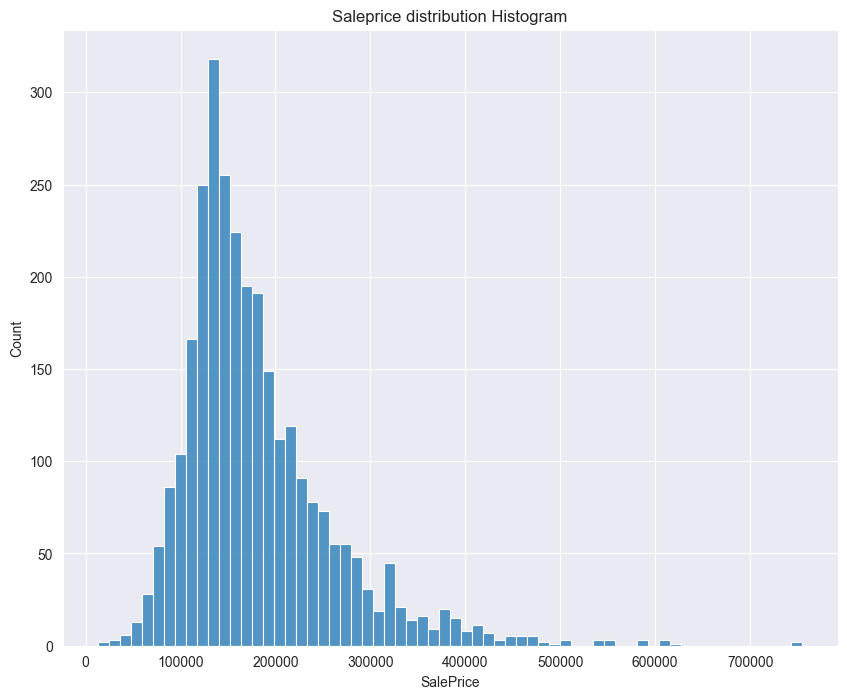

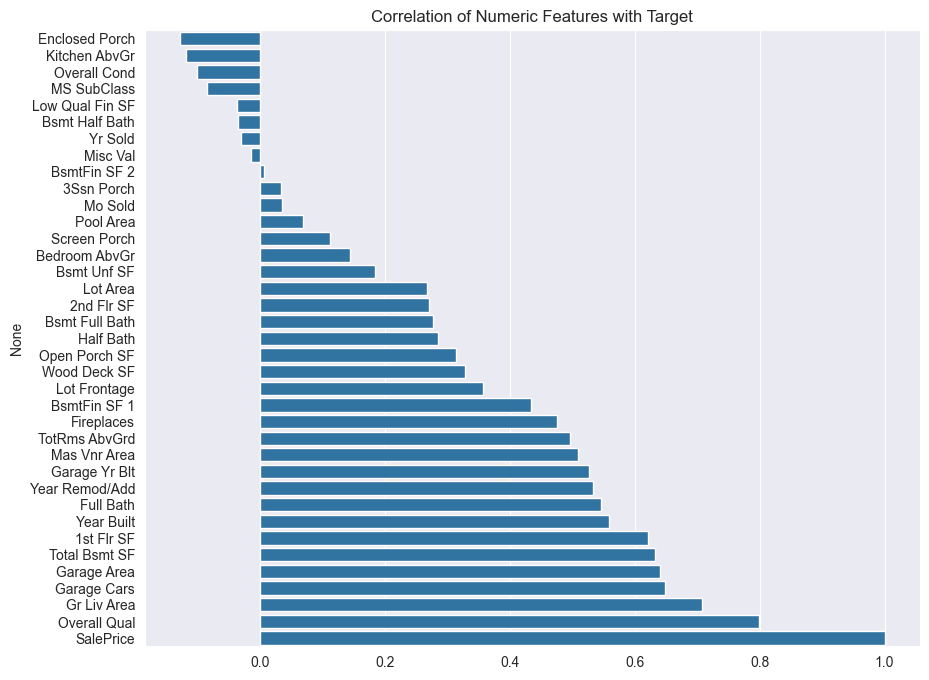

Quality split
1    1108
2    1334
3     488
Name: count, dtype: int64


In [90]:
datapath = "Data/AmesHousing.csv"

df_raw = pd.read_csv(datapath)

df_raw.drop(columns=["PID","Order"], inplace=True)

plt.figure(figsize=(10,8))
sns.histplot(data=df_raw, x='SalePrice')
plt.title("Saleprice distribution Histogram")
plt.show()

corr = df_raw.corr(numeric_only=True)['SalePrice'].sort_values()
plt.figure(figsize=(10,8))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation of Numeric Features with Target")
plt.show()

df_raw['Quality split'] = pd.qcut(
    df_raw['Overall Qual'],
    q=3,                 # 4 roughly equal-sized groups
    labels=[1, 2, 3]
)


print(df_raw['Quality split'].value_counts().sort_index())

The Barplot above only shows the correlation between the numerical columns and not the categorical. Due to there being many categorical columns, it was decided to only use the 6 categorical features with the strongest correlation to the SalePrice in order to avoid longer compute times for the models used later. A code was generated by ChatGPT to determine which of the categorical features had the strongest correlation.

['Alley', 'Neighborhood', 'Mas Vnr Type', 'Exter Qual', 'Foundation', 'Exterior 1st']


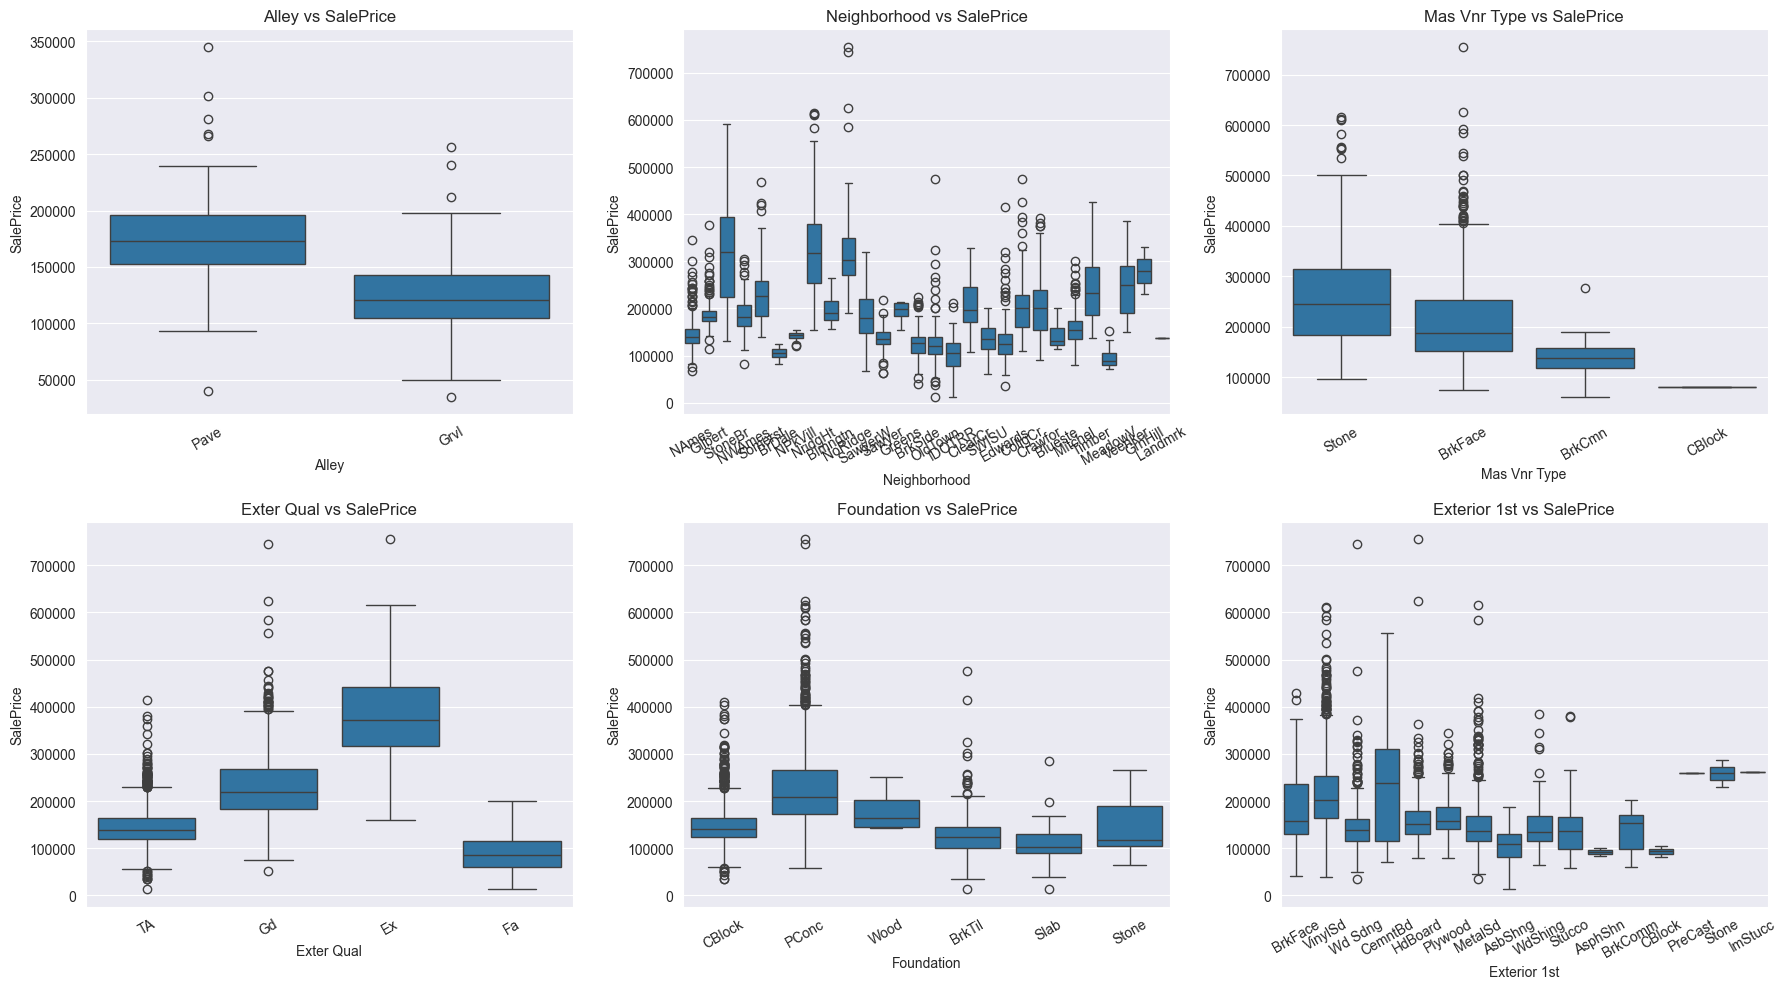

In [91]:
def correlation_ratio(categories, values):
    """
    Correlation ratio (eta squared) for categorical -> numerical.
    """
    categories = pd.Series(categories)
    values = pd.Series(values)
    cat_groups = [values[categories == cat] for cat in categories.unique()]
    n_total = len(values)
    grand_mean = values.mean()
    ss_between = sum([len(g) * (g.mean() - grand_mean) ** 2 for g in cat_groups])
    ss_total = ((values - grand_mean) ** 2).sum()
    return np.sqrt(ss_between / ss_total)

target = "SalePrice"   # <-- your target column name
cat_cols = df_raw.select_dtypes(exclude='number').columns

corr_scores = {}
for col in cat_cols:
    eta = correlation_ratio(df_raw[col], df_raw[target])
    corr_scores[col] = eta

# Sort and pick top 6
top6_cats = sorted(corr_scores, key=corr_scores.get, reverse=True)[:6]
print(top6_cats)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows × 3 columns
axes = axes.flatten()

for ax, col in zip(axes, top6_cats):
    sns.boxplot(x=col, y=target, data=df_raw, ax=ax)
    ax.set_title(f"{col} vs {target}", fontsize=12)
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

The dataset is stratified with 'Overall quality' in 4 different bins.  the Overall quality feature was selected because it was the numerical feature with the strongest correlation to SalePrice. The following Shows the prices in the 4 quality bins. The quality bins can be seen as Low quality, Medium-low quality, Medium-high quality, and High-quality. This shows an increasing trend between quality and sale price

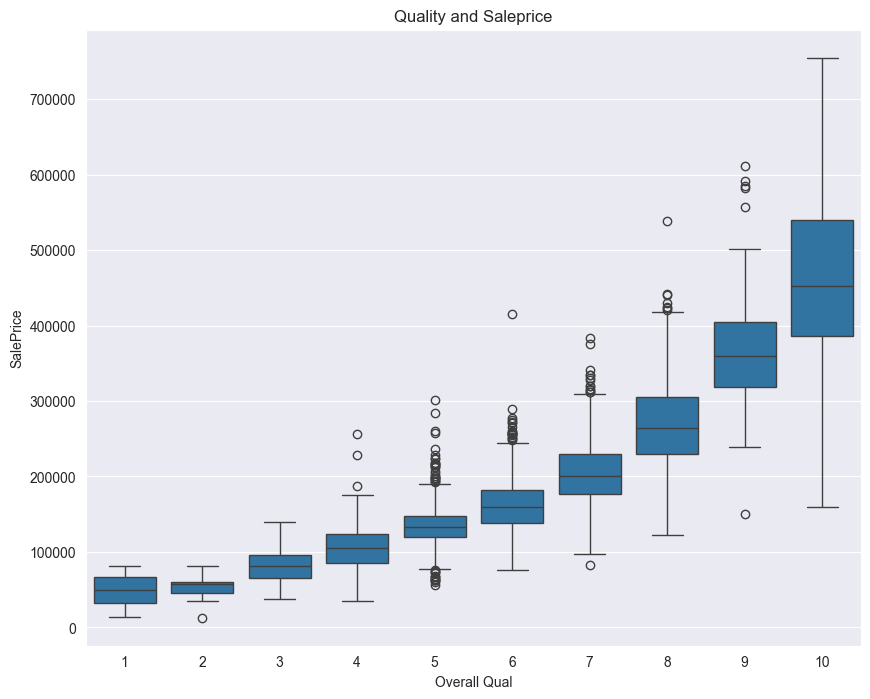

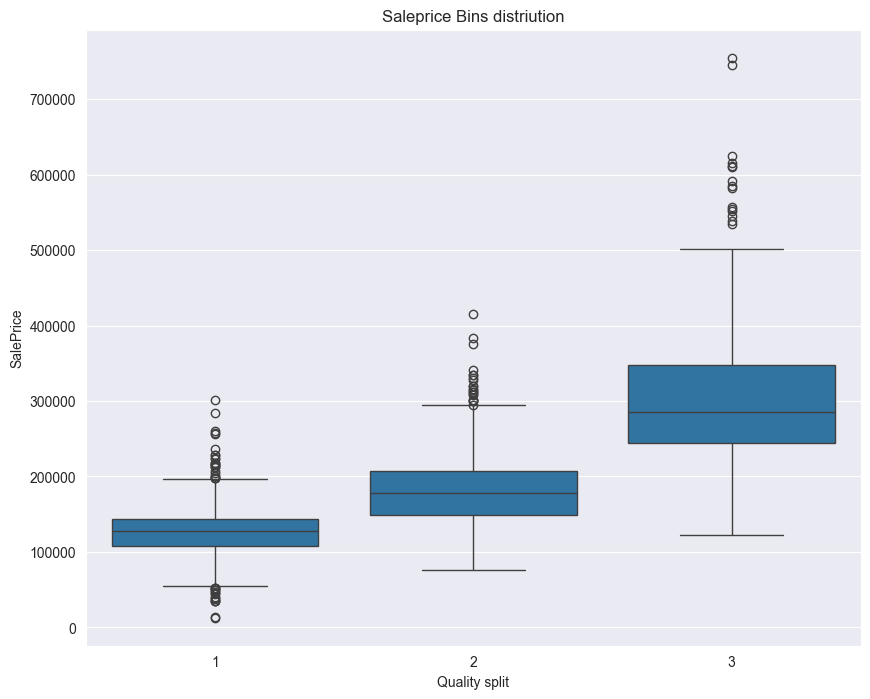

In [92]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df_raw, x='Overall Qual',y='SalePrice')
plt.title("Quality and Saleprice")
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(data=df_raw, x='Quality split',y='SalePrice')
plt.title("Saleprice Bins distriution")
plt.show()


# Splitting the data

A stratified split is performed with a 80% training set and a 20% test set, with an equal distribution of the 3 Qualities being preserved in the different sets. After the split is done the quality split helper column is dropped after we have confirmed that the distribution is similar.

In [93]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df_raw, df_raw["Quality split"]):
 strat_train_set = df_raw.iloc[train_idx].copy()
 strat_test_set = df_raw.iloc[test_idx].copy()



def proportions(s): return s.value_counts(normalize=True).sort_index()

prop_table = pd.DataFrame({
 'overall': proportions(df_raw['Quality split']),
 'train': proportions(strat_train_set['Quality split']),
 'test': proportions(strat_test_set['Quality split'])})

print(prop_table)

for s in (strat_train_set, strat_test_set):
 s.drop(columns=["Quality split"], inplace=True)

X_train = strat_train_set.drop(columns=['SalePrice'])
y_train = strat_train_set['SalePrice'].copy()
X_test = strat_test_set.drop(columns=['SalePrice'])
y_test = strat_test_set['SalePrice'].copy()


                overall     train      test
Quality split                              
1              0.378157  0.377986  0.378840
2              0.455290  0.455205  0.455631
3              0.166553  0.166809  0.165529


# Regression models
Next the regression models is performed with the 6 strongest categorical features, as well as all of the numerical features. ChatGPT was used to speed up the coding process for the models. The 3 chosen models are linear regression, polynomial feature linear regression, and random forest regression

## Linear regression

In [94]:

# --------------------------
# 1️⃣ Select numeric + strong categorical features
# --------------------------
# Example strong categorical features (you can adjust)
strong_cat_cols = ['Alley','Neighborhood', 'Mas Vnr Type', 'Exter Qual', 'Foundation', 'Exterior 1st']
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'SalePrice']  # drop target if present

# Filter categorical columns to those in the dataset
cat_cols = [c for c in strong_cat_cols if c in X_train.columns]

# --------------------------
# 2️⃣ Create transformers
# --------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
])

# --------------------------
# 3️⃣ Build pipeline with log-transform
# --------------------------
linreg = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

# Log-transform target
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# --------------------------
# 4️⃣ Fit and predict
# --------------------------
linreg.fit(X_train, y_train_log)
y_pred_log = linreg.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale

# --------------------------
# 5️⃣ Evaluate
# --------------------------
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:,.2f}")
print(f"Linear Regression R^2: {r2:.3f}")# Log-transform target


Linear Regression RMSE: 19,962.26
Linear Regression R^2: 0.929


## Polynomial features

In [95]:

#Polynomial features

poly_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])

# Fit
poly_pipeline.fit(X_train, y_train_log)


# Predict
y_pred_poly = poly_pipeline.predict(X_test)

# Evaluate
rmse_poly = np.sqrt(mean_squared_error(y_test_log, y_pred_poly))
r2_poly = r2_score(y_test_log, y_pred_poly)

print()
print(f"Polynomial Linear Regression RMSE: {rmse_poly:,.2f}")
print(f"Polynomial Linear Regression R^2: {r2_poly:.3f}")


Polynomial Linear Regression RMSE: 4.22
Polynomial Linear Regression R^2: -124.541


## Random forest regressor

In [96]:

rf_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=42
    ))
])

# Fit
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print()
print(f"Random Forest RMSE: {rmse_rf:,.2f}")
print(f"Random Forest R^2: {r2_rf:.3f}")




Random Forest RMSE: 21,874.26
Random Forest R^2: 0.914


Based on the performance of the 3 models we see that the Linear regression performed the best with an RMSE of roughly 20 000 usd and R^2 of 9.29 indicating it explains a good amount of the variance in the dataset and has only a small error when it comes to the price prediction. The second best was the random forest regressor which performed similarily, but slighly worse. Lastly the polynomial feature shows strong signs of overfitting as it has a very low RMSE, as well as a high negative R^2.

# Questions

### 1)
The most important numerical feature was the overall quality of the house, followed by gr liv area and garage cars. Where as the most important categorical feature was the Alley, followed by the neighborhood.

### 2)
The correlation between each feature was determined by using the pairwise correlation with the pandas packages of each numerical feature to the SalePrice. (Add text for the categorical)

### 3)
The numerical correlations were visualised by a barplot in order to make it easy to interpret which features had the strongest correlation. Similaily boxplots were used to see how the 6 strongest categorical features affected the saleprice. Lastly the boxplots were used to check how the sale price was affected by the overall quality of the sold house.

### 4)
Due to the strong correlation between Overall quality and the saleprice it was decided to stratify the training and test sets by this feature in order to have an equal distribution among the two sets. At first there was no stratified split done and the models performed poorly. But after the split was done it was found that the models performed better.

### 5)
Nothing was done regarding the different neighbourhoods and so the dataset fed to the model most likely has a bias in regards to the distribution of rich and poor neighborhoods (Needs to be verified.)

### 6)




